# Import Packages

In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

2025-06-29 11:36:32.267746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751196992.757650      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751196992.872699      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Unzipping Training Data

In [3]:
if not os.path.exists("/kaggle/working/train"):
    !unzip -q /kaggle/input/dogs-vs-cats/train.zip

In [4]:
train_path = '/kaggle/working/train'
len(os.listdir(train_path))

25000

# Some Visualization

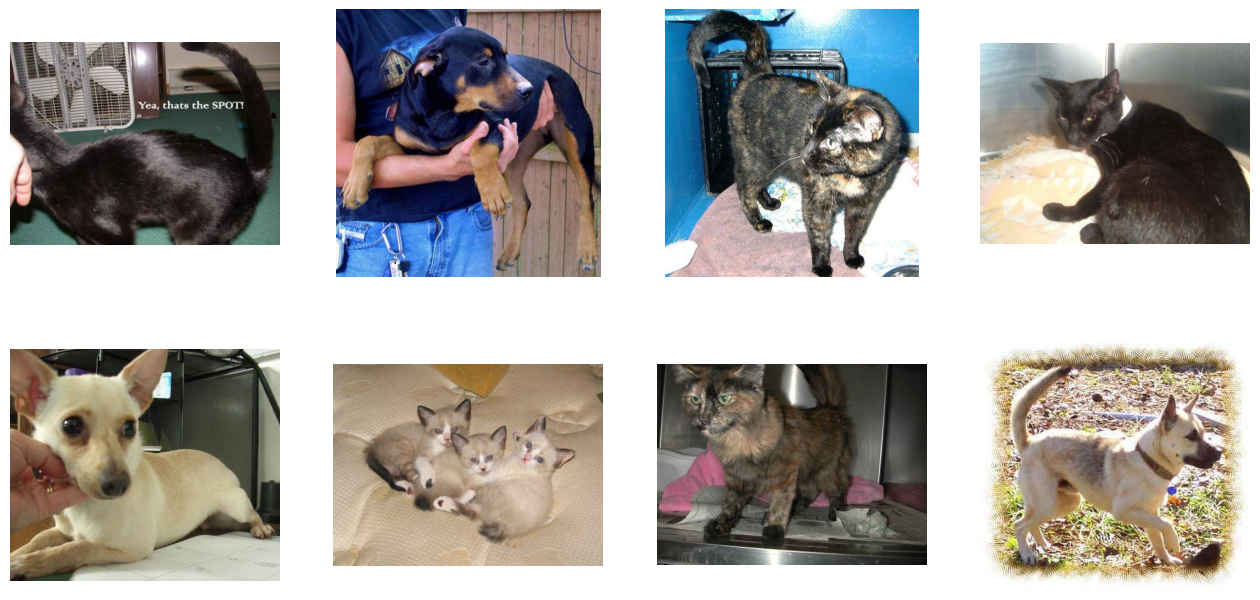

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(16,16))

images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [6]:
os.listdir(train_path)[:20]

['cat.2788.jpg',
 'dog.623.jpg',
 'dog.11038.jpg',
 'dog.7431.jpg',
 'cat.8550.jpg',
 'dog.7831.jpg',
 'cat.10250.jpg',
 'dog.7507.jpg',
 'cat.1261.jpg',
 'cat.5448.jpg',
 'cat.4510.jpg',
 'cat.5616.jpg',
 'cat.5052.jpg',
 'cat.8913.jpg',
 'dog.2742.jpg',
 'cat.6608.jpg',
 'dog.10906.jpg',
 'cat.10422.jpg',
 'cat.5046.jpg',
 'cat.170.jpg']

# Creating Directories to organize our Data

In [7]:
try:
    parent_dir = '/kaggle/working/cats-v-dogs'
    os.mkdir(parent_dir)

    for dir in ['training', 'validation']:
        path = os.path.join(parent_dir , dir)
        os.mkdir(path)
        for dir in ['cats', 'dogs']:
            n_path = os.path.join(path , dir)
            os.mkdir(n_path)
except OSError:
    print('Existed')

In [8]:
src_dir = train_path

cats_train_dir = '/kaggle/working/cats-v-dogs/training/cats'
cats_valid_dir = '/kaggle/working/cats-v-dogs/validation/cats'

dogs_train_dir = '/kaggle/working/cats-v-dogs/training/dogs'
dogs_valid_dir = '/kaggle/working/cats-v-dogs/validation/dogs'

# List of cats names in all training images
cats =[img for img in os.listdir(src_dir) if img[:3] == 'cat']

# List of dogs names in all training images
dogs =[img for img in os.listdir(src_dir) if img[:3] == 'dog']

# Take 10% of training images for validation    
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [9]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)

    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)

    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [10]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  11250
No. of cats for validation:  1250

No. of ALL dogs :  12500
No. of dogs for training:  11250
No. of dogs for validation:  1250


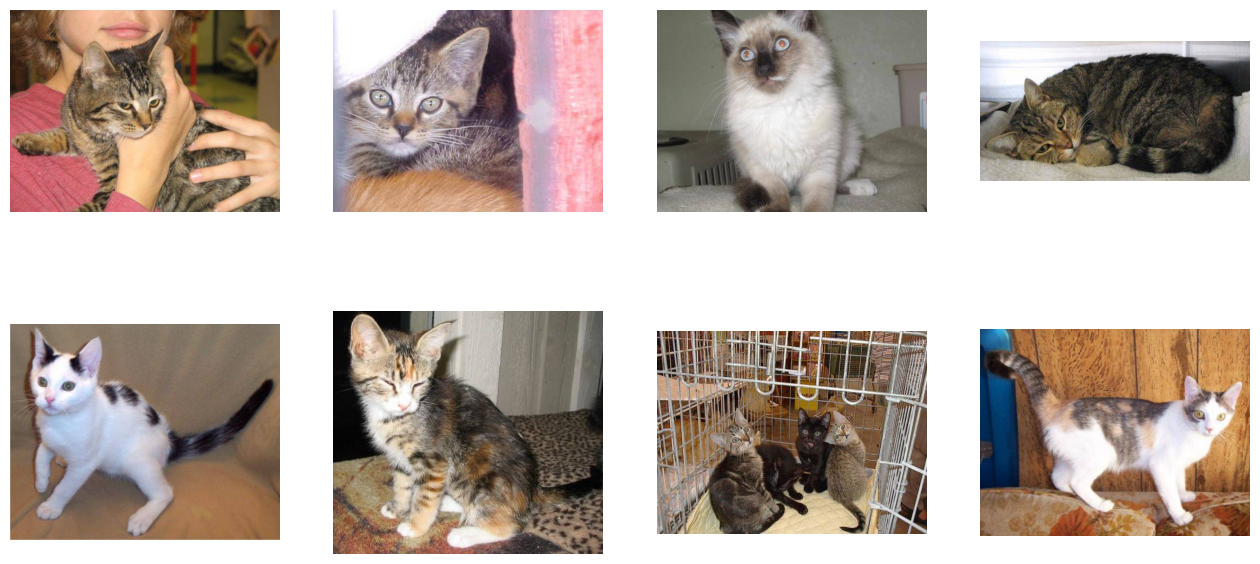

In [11]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

# Image Data Generator
+ **To flow from directory**
+ **Also, we will use it for rescaling**

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)


train_dir = '/kaggle/working/cats-v-dogs/training'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/kaggle/working/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [13]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


**According to Tensorflow Docs:**
> **Deprecated: *tf.keras.preprocessing.image.ImageDataGenerator* is not recommended for new code. Prefer loading images with *tf.keras.utils.image_dataset_from_directory* and transforming the output *tf.data.Dataset* with preprocessing layers.**
[**Check Here**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

**However, we will stick with ImageDataGenerator for its simplicity**

# Modelling

## Base Model

In [14]:
# create model
model = Sequential([  Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                      Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                      Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),

                      
                    Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')  ])

# Compile model 
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1751197030.097890      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751197030.098669      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

**We will fit the model for very few epochs, just for defining the least accuracy we can get**

In [15]:
history = model.fit(train_generator, epochs=5, verbose=1,validation_data=valid_generator)

Epoch 1/5


I0000 00:00:1751197035.109041     116 service.cc:148] XLA service 0x7aeb640043a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751197035.110707     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751197035.110728     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751197035.465675     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/704 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.5124 - loss: 0.7485

I0000 00:00:1751197039.995689     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.6354 - loss: 0.6217 - val_accuracy: 0.7336 - val_loss: 0.5285
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.7770 - loss: 0.4705 - val_accuracy: 0.7864 - val_loss: 0.4493
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8193 - loss: 0.4045 - val_accuracy: 0.8060 - val_loss: 0.4325
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8441 - loss: 0.3563 - val_accuracy: 0.8108 - val_loss: 0.4229
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8657 - loss: 0.3153 - val_accuracy: 0.8272 - val_loss: 0.3865


<Axes: >

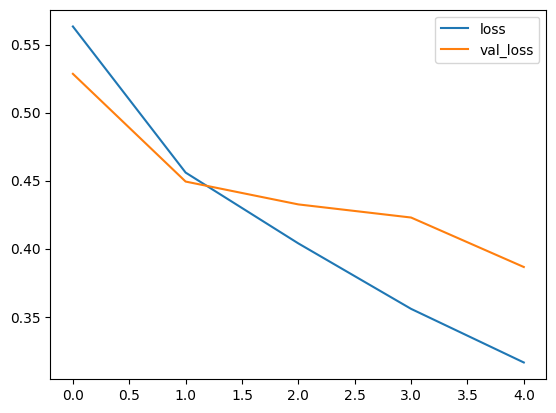

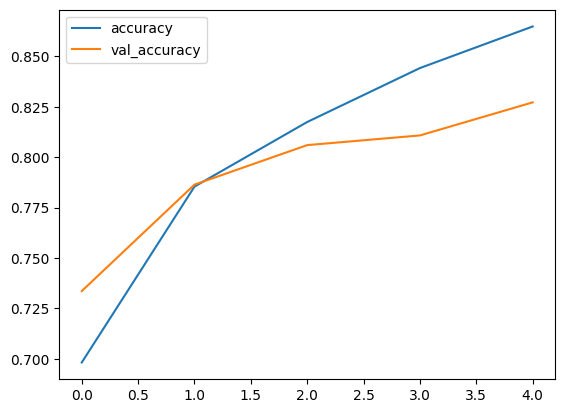

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [17]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Our Base Model Accuracy on Training Data: ", train_acc)
print("Our Base Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.8972 - loss: 0.2584
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8147 - loss: 0.3991
Our Base Model Accuracy on Training Data:  0.8961777687072754
Our Base Model Accuracy on Validation Data:  0.8271999955177307


+ **Some Overfitting**
+ **We will try using Data Augmentation to overcome it**

# Data Augmentation on the fly

* **A technique of artificially increasing the training set by creating modified copies of a dataset using existing data.**
* **Increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation**
* **Enlarge dataset**
* **Avoid Overfitting**


![Augmentation](https://miro.medium.com/v2/resize:fit:960/0*LNtz0G4cngapDH41.png)

**Image Source:** [**Medium Article**](https://medium.com/@tagxdata/data-augmentation-for-computer-vision-9c9ed474291e)

In [18]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/kaggle/working/cats-v-dogs/training'
aug_train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_dir = '/kaggle/working/cats-v-dogs/validation'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Augmented Model

In [20]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights.best.hdf5.keras', monitor='val_loss', save_best_only=True)]

# create model
aug_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),

                            Flatten(),
                            Dense(128, activation='relu'),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/kaggle/working/weights.best.hdf5"):
    aug_model.load_weights("weights.best.hdf5")

# Compile model 
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
aug_history = aug_model.fit(aug_train_generator, epochs=10, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8539 - loss: 0.3360 - val_accuracy: 0.8328 - val_loss: 0.3872
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8782 - loss: 0.2934 - val_accuracy: 0.8332 - val_loss: 0.3985
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8910 - loss: 0.2656 - val_accuracy: 0.8452 - val_loss: 0.4040
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.9061 - loss: 0.2312 - val_accuracy: 0.8404 - val_loss: 0.3947
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9277 - loss: 0.1848 - val_accuracy: 0.8424 - val_loss: 0.4176
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9403 - loss: 0.1556 - val_accuracy: 0.8460 - val_loss: 0.4568


<Axes: >

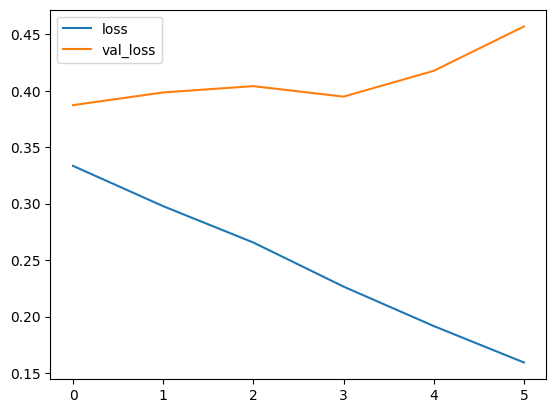

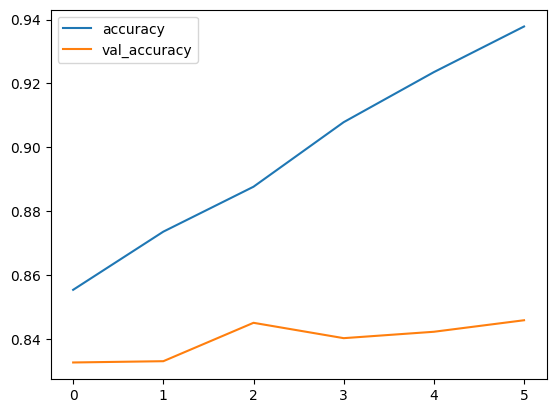

In [25]:
history_df = pd.DataFrame(aug_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [26]:
train_acc = aug_model.evaluate(train_generator)[1]
valid_acc = aug_model.evaluate(valid_generator)[1]
print("Our Augmented Base Model Accuracy on Training Data: ", train_acc)
print("Our Augmented Base Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.9506 - loss: 0.1308
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8482 - loss: 0.4495
Our Augmented Base Model Accuracy on Training Data:  0.9525333046913147
Our Augmented Base Model Accuracy on Validation Data:  0.8460000157356262


+ **Still Overfitting**
+ **We may try more Regularization**

# More Complex Model
* **More Layers**
* **Batch Normalization**
* **Dropout**

In [28]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights2.best.hdf5.keras', monitor='val_loss', save_best_only=True)]

# create model
new_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Flatten(),
                            BatchNormalization(),
                            Dense(128, kernel_regularizer = L2(0.15), bias_regularizer=L2(0.15), activation='relu'),
                            Dropout(rate = 0.5 , seed = 40),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("/kaggle/working/weights2.best.hdf5"):
    new_model.load_weights("weights2.best.hdf5")

# Compile model 
new_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,068,993 (4.08 MB)

 Trainable params: 1,056,449 (4.03 MB)

 Non-trainable params: 12,544 (49.00 KB)

In [29]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.6517 - loss: 4.7972 - val_accuracy: 0.7200 - val_loss: 0.6411
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7717 - loss: 0.5753 - val_accuracy: 0.7596 - val_loss: 0.6124
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.8181 - loss: 0.5101 - val_accuracy: 0.7596 - val_loss: 0.6099
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8371 - loss: 0.4735 - val_accuracy: 0.8512 - val_loss: 0.4482
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8568 - loss: 0.4422 - val_accuracy: 0.8592 - val_loss: 0.4298
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8752 - loss: 0.4066 - val_accuracy: 0.8508 - val_loss: 0.4679
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8859 - loss: 0.3783 - val_accuracy: 0.8684 - val_loss: 0.4255
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8984 - loss: 0.3535 - 

<Axes: >

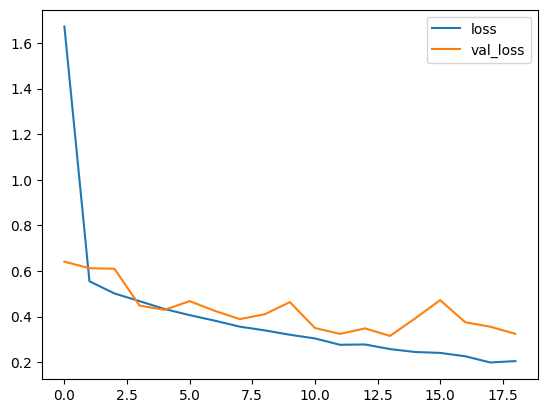

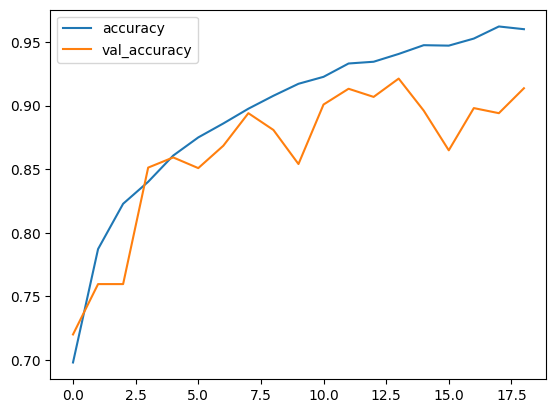

In [30]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [31]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9810 - loss: 0.1559
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9117 - loss: 0.3284
Our New Model Accuracy on Training Data:  0.9826666712760925
Our New Model Accuracy on Validation Data:  0.9136000275611877


+ **Sounds Good!**
+ **We can go farther use More Epochs**
+ **As we use ModelCheckpoint callback, the model will start from the final best weights stoed before**


In [32]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9686 - loss: 0.1810 - val_accuracy: 0.9132 - val_loss: 0.3325
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9679 - loss: 0.1779 - val_accuracy: 0.9140 - val_loss: 0.3210
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9699 - loss: 0.1749 - val_accuracy: 0.9048 - val_loss: 0.3483
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9721 - loss: 0.1648 - val_accuracy: 0.9184 - val_loss: 0.3414
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9759 - loss: 0.1550 - val_accuracy: 0.9232 - val_loss: 0.2982
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9802 - loss: 0.1411 - val_accuracy: 0.9060 - val_loss: 0.3920
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9787 - loss: 0.1449 - val_accuracy: 0.9152 - val_loss: 0.3200
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9800 - loss: 0.1409 - 

<Axes: >

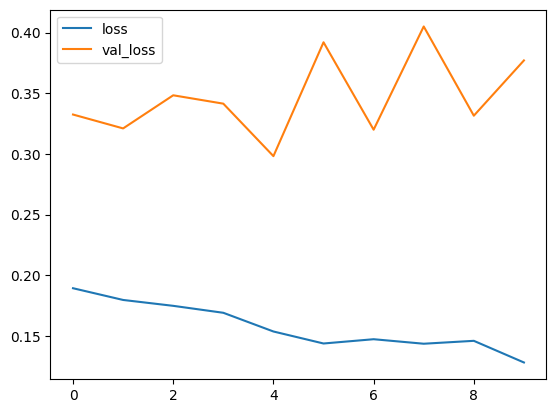

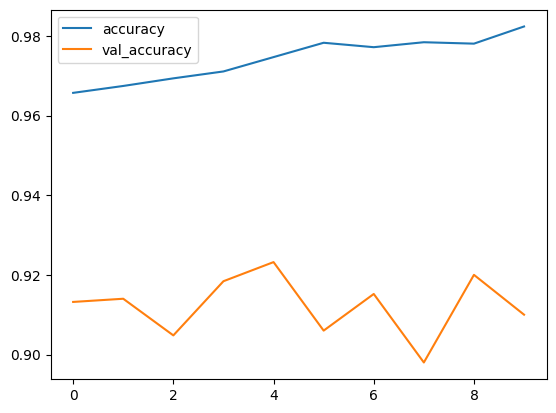

In [33]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [34]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 29s 41ms/step - accuracy: 0.9879 - loss: 0.1208
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9135 - loss: 0.3560
Our New Model Accuracy on Training Data:  0.9874666929244995
Our New Model Accuracy on Validation Data:  0.9100000262260437


+ **Nice!**
+ **Let's try Transfer Learning**

# Transfer Learning
+ **A technique where knowledge learned from a task is re-used in order to boost performance on a related task.**
+ **The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other tasks.**   
+ **Transfer learning is particularly very useful when you have a small training dataset.**  

![](https://cdn-media-1.freecodecamp.org/images/1*tmh4aAYfP-1SGqpqAaim3w.png)

**Image Source:** [**FreeCodeCamp Article**](https://www.freecodecamp.org/news/asl-recognition-using-transfer-learning-918ba054c004/)

 ### Why use transfer learning?

+ **training models with high accuracy requires a lot of data. For example, the ImageNet dataset contains over 1 million images. In the real world, you are unlikely to have such a large dataset.** 
+ **assuming that you had that kind of dataset, you might still not have the resources required to train a model on such a large dataset.**
+ **even if you had the compute resources, you still have to wait for days or weeks to train such a model.** 

### Examples of Pre-trained Models:

+ **training models with high accuracy requires a lot of data. For example, the ImageNet dataset contains over 1 million images. In the real world, you are unlikely to have such a large dataset.** 
+ **assuming that you had that kind of dataset, you might still not have the resources required to train a model on such a large dataset.**
+ **even if you had the compute resources, you still have to wait for days or weeks to train such a model.** 

### How you can use pre-trained models
**There are three ways to use a pre-trained model:**
* **Prediction.**
* **Feature Extraction.**
* **Fine-tuning.**

> **Here, we will use it for Feature Extraction**

### More About Pre-trained Models:
+ [**Keras Docs**](https://keras.io/api/applications/)
+ [**Nice Article**](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96)

**I will use the model included in this [Notebook](http://https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb) from Tensorflow Specialization on Coursera**

In [35]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-06-29 12:15:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 192.178.212.207, 74.125.132.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/kaggle/working//in 100%[===================>]  83.84M   131MB/s    in 0.6s    

2025-06-29 12:15:18 (131 MB/s) - ‘/kaggle/working//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [36]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [37]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 74, 74, 32)     │             96 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 32)     │             96 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 72, 72, 64)     │            192 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 35, 35, 80)     │            240 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 33, 33, 192)    │            576 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [39]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [40]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)         

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 74, 74, 32)     │             96 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 32)     │             96 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 72, 72, 64)     │            192 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 35, 35, 80)     │            240 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 33, 33, 192)    │            576 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [41]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [43]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/weights_tf.best.hdf5.keras', monitor='val_loss', save_best_only=True)]

# Train the model.
history = model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.9370 - loss: 0.1858 - val_accuracy: 0.9716 - val_loss: 0.0735
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9842 - loss: 0.0433 - val_accuracy: 0.9712 - val_loss: 0.0795
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.9932 - loss: 0.0193 - val_accuracy: 0.9720 - val_loss: 0.0972
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9988 - loss: 0.0063 - val_accuracy: 0.9732 - val_loss: 0.0965
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9668 - val_loss: 0.1134
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.9999 - loss: 7.3820e-04 - val_accuracy: 0.9720 - val_loss: 0.1165


704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 1.0000 - loss: 2.7523e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9695 - loss: 0.1157
Transfer Learning Model Accuracy on Training Data:  0.9999111294746399
Transfer Learning Model Accuracy on Validation Data:  0.972000002861023


<Axes: >

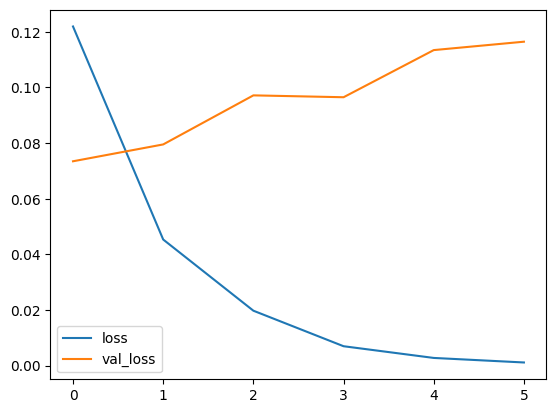

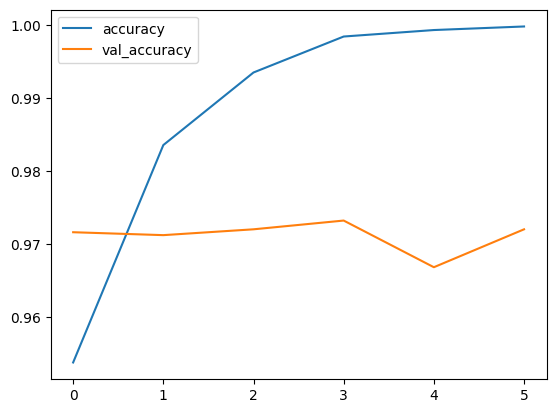

In [44]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()